In [ ]:
%pip install datasets
%pip install ibm-watsonx-ai

In [41]:
import random
import json

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np

In [42]:
from ibm_watsonx_ai.foundation_models import Model

In [3]:
data_df = pd.read_csv('https://huggingface.co/datasets/MohamedZayton/AMINA/resolve/main/BBC/BBC.csv')

In [4]:
data_df.isna().sum()

,0
Title,0
Article,0
Article_Class,0
Write_By,4773
Published Date,0


In [5]:
processed_df = data_df.copy()
processed_df['Write_By'] = processed_df['Write_By'].str.strip()

In [6]:
processed_df.dropna(subset=['Write_By'], inplace=True)

In [7]:
processed_df.groupby('Write_By').count()['Article'].values.max()

71

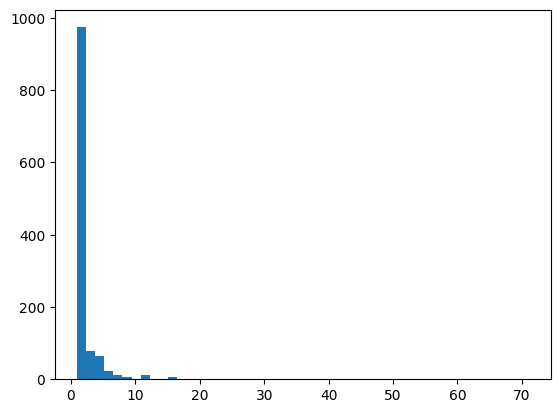

In [8]:
plt.hist(processed_df.groupby('Write_By').count()['Article'].values, bins=50)
plt.show()

In [9]:
n_top_authors = 10
top_authors = processed_df.groupby('Write_By').count()['Article'].sort_values(ascending=False).head(n_top_authors)
top_authors_names = top_authors.index.tolist()
top_authors

,Article
Write_By,
وليد بدران,71
قسم المتابعة الإعلامية,51
جيمس غالغر,42
ميشيل روبرتس,26
ديفيد غريتن,26
جيمس غالاغر,22
بول كيربي,20
حسام فازولا,16
زوي كلاينمان,15


In [10]:
top_authors_df = processed_df[processed_df['Write_By'].isin(top_authors.index)]

In [11]:
def get_authors_correct_and_incorrect_samples(author_name, n_correct_samples, n_incorrect_samples, df=top_authors_df):

    author_mask = df['Write_By'] == author_name
    author_df = df[author_mask]
    no_author_df = df[~author_mask]
    correct_samples = author_df.sample(n_correct_samples)['Article'].tolist()
    incorrect_samples = no_author_df.sample(n_incorrect_samples)['Article'].tolist()

    return correct_samples, incorrect_samples

## Initialzie the model

In [12]:
credentials = {"url": "https://eu-de.ml.cloud.ibm.com", "apikey": "JsA-9hFRsH1msnDzUkcRpoUhSi3r3dfQMAj8Ic9yRiNg"}

project_id = "43ada3b1-5d11-42e8-9ef1-c718b99c05e1"
model_id = "sdaia/allam-1-13b-instruct"

parameters = {
    # "decoding_method": "greedy",
    "max_new_tokens": 900,
    # "repetition_penalty": 1.05
}

In [13]:
# Initialize the model
model = Model(
    model_id=model_id,
    params=parameters,
    credentials=credentials,
    project_id=project_id
)

## Testing the performance

In [14]:
def get_sample(author_name, n_prompt_example_articles, correct_prob=0.5):

    n_incorrect_articles = 1
    n_correct_articles = n_prompt_example_articles
    is_correct = random.random() <= correct_prob
    if is_correct:
        n_correct_articles += 1
        n_incorrect_articles = 0
    correct_samples, incorrect_samples = get_authors_correct_and_incorrect_samples(author_name, n_correct_articles, n_incorrect_articles)

    res = correct_samples+incorrect_samples

    prompt_examples = res[:-1]
    test_article = res[-1]

    return prompt_examples, test_article, is_correct

In [32]:
n_test_samples = 100
n_prompt_examples = 3
test_samples = []

for i in tqdm(range(n_test_samples)):

    author_name = random.choice(top_authors_names)
    test_samples.append(get_sample(author_name, n_prompt_examples))

100%|██████████| 100/100 [00:00<00:00, 813.47it/s]


In [87]:
PROMPT_TEMPLATE = """
1. You are provided {n_examples} articles known to be written by the author {author_name} in Arabic, along with one unknown article.
2. Your job is to analyse the style of the known articles, and judge whether the mystery article is written by the same author or not.
3. Use this JSON format to answer:
{{
    "answer": true|false
}}</s>

4. True means the author of unknown article is the same as the known one and their style matches. False means the style and author don't match.
5. DO NOT GIVE ANY EXTRA INFORMATION BESIDES THE JSON.

Let's begin.

Here are the known articles:
{known_articles}

Here is the mystery article:
{mystery_article}

JSON Answer:
"""


JSON_ONLY_PROMPT_TEMPLATE = """
Keep only the JSON part from this text and remove the rest.
If the JSON format is wrong, fix it.
Do not add anything else. I want to be able to parse it as a valid JSON.

Full Text:
{bad_text}

JSON ONLY TEXT:
"""

In [88]:
responses = []
ground_truth = []

for examples, test_article, is_correct in tqdm(test_samples):

    examples = [exp[:2000] for exp in examples]

    prompt = PROMPT_TEMPLATE.format(
        n_examples=n_prompt_examples,
        author_name=author_name,
        known_articles='\n------------------------------'.join(examples),
        mystery_article=test_article[:2000]
    )
    response = model.generate_text(prompt)
    try:
        response = json.loads(response)
    except json.JSONDecodeError:
        print('Bad JSON found.')
        response = model.generate_text(JSON_ONLY_PROMPT_TEMPLATE.format(bad_text=response))
        response = json.loads(response)

    responses.append(response)
    ground_truth.append(is_correct)

  0%|          | 0/100 [00:00<?, ?it/s]

Bad JSON found.


  1%|          | 1/100 [00:05<09:09,  5.55s/it]

Bad JSON found.


  2%|▏         | 2/100 [00:12<10:00,  6.12s/it]

Bad JSON found.


  3%|▎         | 3/100 [00:17<09:26,  5.84s/it]

Bad JSON found.


  4%|▍         | 4/100 [00:21<08:20,  5.21s/it]

Bad JSON found.


  5%|▌         | 5/100 [00:27<08:31,  5.38s/it]

Bad JSON found.


  6%|▌         | 6/100 [00:32<08:22,  5.34s/it]

Bad JSON found.


  7%|▋         | 7/100 [00:37<08:06,  5.23s/it]

Bad JSON found.


  8%|▊         | 8/100 [00:41<07:10,  4.67s/it]

Bad JSON found.


  9%|▉         | 9/100 [00:44<06:25,  4.24s/it]

Bad JSON found.


 10%|█         | 10/100 [00:49<06:52,  4.58s/it]

Bad JSON found.


 11%|█         | 11/100 [00:54<06:43,  4.53s/it]

Bad JSON found.


 12%|█▏        | 12/100 [01:00<07:31,  5.14s/it]

Bad JSON found.


 13%|█▎        | 13/100 [01:06<07:32,  5.20s/it]

Bad JSON found.


 14%|█▍        | 14/100 [01:10<07:12,  5.03s/it]

Bad JSON found.


 15%|█▌        | 15/100 [01:16<07:32,  5.33s/it]

Bad JSON found.


 16%|█▌        | 16/100 [01:21<07:01,  5.02s/it]

Bad JSON found.


 17%|█▋        | 17/100 [01:27<07:28,  5.40s/it]

Bad JSON found.


 18%|█▊        | 18/100 [01:33<07:50,  5.74s/it]

Bad JSON found.


 19%|█▉        | 19/100 [01:38<07:12,  5.34s/it]

Bad JSON found.


 20%|██        | 20/100 [01:43<07:08,  5.35s/it]

Bad JSON found.


 21%|██        | 21/100 [01:48<06:54,  5.24s/it]

Bad JSON found.


 22%|██▏       | 22/100 [01:53<06:31,  5.02s/it]

Bad JSON found.


 23%|██▎       | 23/100 [01:57<06:12,  4.84s/it]

Bad JSON found.


 24%|██▍       | 24/100 [02:03<06:36,  5.22s/it]

Bad JSON found.


 25%|██▌       | 25/100 [02:06<05:38,  4.51s/it]

Bad JSON found.


 26%|██▌       | 26/100 [02:11<05:41,  4.61s/it]

Bad JSON found.


 27%|██▋       | 27/100 [02:14<05:03,  4.15s/it]

Bad JSON found.


 28%|██▊       | 28/100 [02:17<04:41,  3.91s/it]

Bad JSON found.


 29%|██▉       | 29/100 [02:23<05:03,  4.27s/it]

Bad JSON found.


 30%|███       | 30/100 [02:27<05:08,  4.41s/it]

Bad JSON found.


 31%|███       | 31/100 [02:32<05:05,  4.43s/it]

Bad JSON found.


 32%|███▏      | 32/100 [02:38<05:32,  4.90s/it]

Bad JSON found.


 33%|███▎      | 33/100 [02:42<05:15,  4.71s/it]

Bad JSON found.


 34%|███▍      | 34/100 [02:47<05:24,  4.92s/it]

Bad JSON found.


 35%|███▌      | 35/100 [02:52<05:11,  4.79s/it]

Bad JSON found.


 36%|███▌      | 36/100 [02:58<05:40,  5.32s/it]

Bad JSON found.


 37%|███▋      | 37/100 [03:04<05:47,  5.52s/it]

Bad JSON found.


 38%|███▊      | 38/100 [03:09<05:21,  5.18s/it]

Bad JSON found.


 39%|███▉      | 39/100 [03:14<05:08,  5.05s/it]

Bad JSON found.


 40%|████      | 40/100 [03:21<05:41,  5.70s/it]

Bad JSON found.


 41%|████      | 41/100 [03:24<04:47,  4.88s/it]

Bad JSON found.


 42%|████▏     | 42/100 [03:30<05:09,  5.34s/it]

Bad JSON found.


 43%|████▎     | 43/100 [03:34<04:43,  4.97s/it]

Bad JSON found.


 44%|████▍     | 44/100 [03:44<05:54,  6.33s/it]

Bad JSON found.


 45%|████▌     | 45/100 [03:48<05:14,  5.71s/it]

Bad JSON found.


 46%|████▌     | 46/100 [03:52<04:40,  5.19s/it]

Bad JSON found.


 47%|████▋     | 47/100 [03:57<04:35,  5.20s/it]

Bad JSON found.


 48%|████▊     | 48/100 [04:00<03:58,  4.59s/it]

Bad JSON found.


 49%|████▉     | 49/100 [04:06<04:17,  5.04s/it]

Bad JSON found.


 50%|█████     | 50/100 [04:12<04:13,  5.07s/it]

Bad JSON found.


 51%|█████     | 51/100 [04:16<04:03,  4.97s/it]

Bad JSON found.


 52%|█████▏    | 52/100 [04:20<03:43,  4.66s/it]

Bad JSON found.


 53%|█████▎    | 53/100 [04:25<03:34,  4.56s/it]

Bad JSON found.


 54%|█████▍    | 54/100 [04:30<03:37,  4.73s/it]

Bad JSON found.


 55%|█████▌    | 55/100 [04:37<04:01,  5.37s/it]

Bad JSON found.


 56%|█████▌    | 56/100 [04:41<03:47,  5.18s/it]

Bad JSON found.


 57%|█████▋    | 57/100 [04:46<03:40,  5.12s/it]

Bad JSON found.


 58%|█████▊    | 58/100 [04:50<03:17,  4.71s/it]

Bad JSON found.


 59%|█████▉    | 59/100 [04:55<03:09,  4.63s/it]

Bad JSON found.


 60%|██████    | 60/100 [05:01<03:29,  5.24s/it]

Bad JSON found.


 61%|██████    | 61/100 [05:07<03:31,  5.42s/it]

Bad JSON found.


 62%|██████▏   | 62/100 [05:12<03:24,  5.38s/it]

Bad JSON found.


 63%|██████▎   | 63/100 [05:18<03:21,  5.45s/it]

Bad JSON found.


 64%|██████▍   | 64/100 [05:22<03:02,  5.06s/it]

Bad JSON found.


 65%|██████▌   | 65/100 [05:26<02:40,  4.60s/it]

Bad JSON found.


 66%|██████▌   | 66/100 [05:30<02:35,  4.56s/it]

Bad JSON found.


 67%|██████▋   | 67/100 [05:34<02:20,  4.26s/it]

Bad JSON found.


 68%|██████▊   | 68/100 [05:38<02:16,  4.26s/it]

Bad JSON found.


 69%|██████▉   | 69/100 [05:43<02:19,  4.51s/it]

Bad JSON found.


 70%|███████   | 70/100 [05:47<02:06,  4.22s/it]

Bad JSON found.


 71%|███████   | 71/100 [05:52<02:17,  4.73s/it]

Bad JSON found.


 72%|███████▏  | 72/100 [05:56<02:02,  4.37s/it]

Bad JSON found.


 73%|███████▎  | 73/100 [06:05<02:34,  5.74s/it]

Bad JSON found.


 74%|███████▍  | 74/100 [06:10<02:22,  5.50s/it]

Bad JSON found.


 75%|███████▌  | 75/100 [06:13<01:58,  4.76s/it]

Bad JSON found.


 76%|███████▌  | 76/100 [06:17<01:52,  4.67s/it]

Bad JSON found.


 77%|███████▋  | 77/100 [06:23<01:55,  5.03s/it]

Bad JSON found.


 78%|███████▊  | 78/100 [06:29<01:57,  5.32s/it]

Bad JSON found.


 79%|███████▉  | 79/100 [06:32<01:36,  4.62s/it]

Bad JSON found.


 80%|████████  | 80/100 [06:36<01:28,  4.45s/it]

Bad JSON found.


 81%|████████  | 81/100 [06:43<01:37,  5.13s/it]

Bad JSON found.


 82%|████████▏ | 82/100 [06:49<01:38,  5.45s/it]

Bad JSON found.


 83%|████████▎ | 83/100 [06:54<01:29,  5.27s/it]

Bad JSON found.


 84%|████████▍ | 84/100 [06:59<01:22,  5.16s/it]

Bad JSON found.


 85%|████████▌ | 85/100 [07:04<01:14,  4.99s/it]

Bad JSON found.


 86%|████████▌ | 86/100 [07:10<01:15,  5.37s/it]

Bad JSON found.


 87%|████████▋ | 87/100 [07:16<01:12,  5.57s/it]

Bad JSON found.


 88%|████████▊ | 88/100 [07:22<01:08,  5.74s/it]

Bad JSON found.


 89%|████████▉ | 89/100 [07:26<00:58,  5.32s/it]

Bad JSON found.


 90%|█████████ | 90/100 [07:33<00:56,  5.70s/it]

Bad JSON found.


 91%|█████████ | 91/100 [07:40<00:55,  6.14s/it]

Bad JSON found.


 92%|█████████▏| 92/100 [07:45<00:47,  5.94s/it]

Bad JSON found.


 93%|█████████▎| 93/100 [07:49<00:35,  5.08s/it]

Bad JSON found.


 94%|█████████▍| 94/100 [07:53<00:29,  4.98s/it]

Bad JSON found.


 95%|█████████▌| 95/100 [08:03<00:31,  6.34s/it]

Bad JSON found.


 96%|█████████▌| 96/100 [08:07<00:22,  5.62s/it]

Bad JSON found.


 97%|█████████▋| 97/100 [08:11<00:15,  5.27s/it]

Bad JSON found.


 98%|█████████▊| 98/100 [08:17<00:10,  5.30s/it]

Bad JSON found.


 99%|█████████▉| 99/100 [08:23<00:05,  5.49s/it]

Bad JSON found.


100%|██████████| 100/100 [08:27<00:00,  5.08s/it]


In [89]:
response

{'answer': True}

In [91]:
predicted = [res['answer'] for res in tqdm(responses)]

100%|██████████| 100/100 [00:00<00:00, 344642.89it/s]


In [92]:
ground_truth = np.array(ground_truth)
predicted = np.array(predicted)

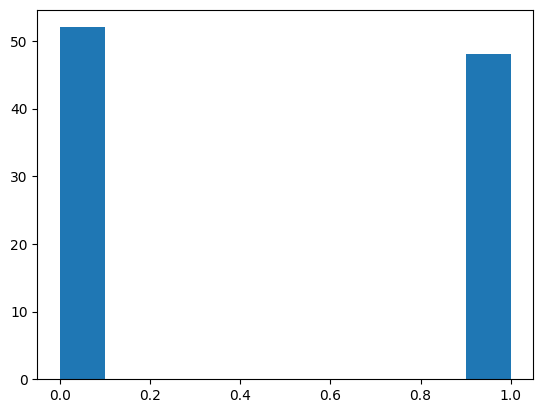

In [94]:
plt.hist(ground_truth.astype(int))
plt.show()

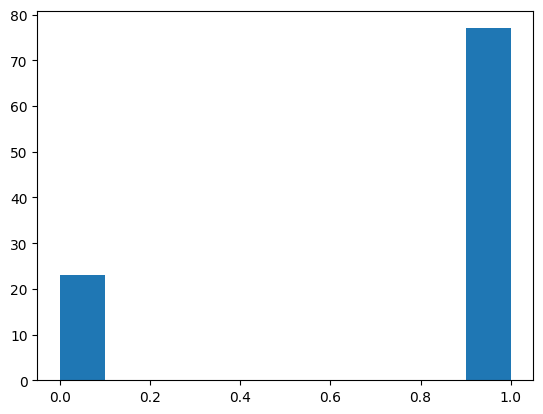

In [95]:
plt.hist(predicted.astype(int))
plt.show()

In [96]:
(predicted == ground_truth).sum()/len(predicted)

0.53